# Лабораторная работа №5 (Проведение исследований с градиентным бустингом)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from itertools import product
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

# 1. Выбор начальных условий

### a. Выбрать набор данных для задачи классификации - Задача по оценке Качества вина
1 - fixed acidity - фиксированная кислотность\
2 - volatile acidity - летучая кислотность\
3 - citric acid - лимонная кислота\
4 - residual sugar - остаточный сахар\
5 - chlorides - хлориды\
6 - free sulfur dioxide - свободный диоксид серы\
7 - total sulfur dioxide - общий диоксид серы\
8 - density - плотность\
9 - pH\
10 - sulphates - сульфаты\
11 - alcohol - спирт\
Выходная переменная (на основе сенсорных данных):\
12 - quality - качество (оценка от 0 до 10)

### b.Выбрать набор данных для задачи регрессии - Задача по предсказанию баллов за экзамен у студентов
1 - student_id - ID студента\
2 - age - возраст\
3 - gender - пол\
4 - major - специальность\
5 - study_hours_per_day - учебные часы в день\
6 - social_media_hours - часы в соцсетях\
7 - netflix_hours - часы просмотра Netflix\
8 - part_time_job - подработка\
9 - attendance_percentage - процент посещаемости\
10 - sleep_hours - часы сна\
11 - diet_quality - качество питания\
12 - exercise_frequency - частота занятий спортом\
13 - parental_education_level - уровень образования родителей\
14 - internet_quality - качество интернета\
15 - mental_health_rating - оценка психического здоровья\
16 - extracurricular_participation - участие во внеурочной деятельности\
17 - previous_gpa - предыдущий средний балл\
18 - semester - семестр\
19 - stress_level - уровень стресса\
20 - dropout_risk - риск отчисления\
21 - social_activity - социальная активность\
22 - screen_time - время у экрана\
23 - study_environment - учебная среда\
24 - access_to_tutoring - доступ к репетиторству\
25 - family_income_range - диапазон дохода семьи\
26 - parental_support_level - уровень поддержки родителей\
27 - motivation_level - уровень мотивации\
28 - exam_anxiety_score - балл тревожности на экзаменах\
29 - learning_style - стиль обучения\
30 - time_management_score - балл управления временем\
Выходная переменная:\
31 - exam_score - оценка за экзамен\

In [5]:
Wine_data = pd.read_csv('data/classification/WineQT.csv').set_index('Id')
Student_data = pd.read_csv('data/Regression/enhanced_student.csv').set_index('student_id')

### c. Выбрать метрики качества и обосновать их выбор

#### Метрики выбранные для Датасета про Качество вина (Классификация):
1.Accuracy - Самая базовая метрика, доля правильно предсказанных. Если классы сбалансированы\
2.Precision-weighted - если важно не завышать оценки\
3.recall-weighted - если важно не занижать оценки\
4.F1-score (weighted) - Метрика для случая если целевая переменная имеет сильный дисбаланс классов, баланс precision/recall

#### Метрики выбранные для Датасета про студентов (Регрессии):
1.MAE (Mean Absolute Error) - интерпретируем в исходных единицах\
2.RMSE (Root Mean Square Error) - штрафует за большие ошибки\
3.MAPE (Mean Absolute Percentage Error) - относительная ошибка в %

# 2.Создание бейзлайна и оценка качества

Перед началом создания и обучения моделей закодируем данные в Датасете студентов для корректной работы моделей sklearn

In [13]:
categorical_cols = Student_data.select_dtypes(include=['object']).columns # Берём все категориальные данные

binary_cols = [col for col in categorical_cols if Student_data[col].nunique() == 2] # Разделяем на бинарные и небинарные
non_binary_cols = [col for col in categorical_cols if Student_data[col].nunique() > 2]
Student_data = pd.get_dummies(Student_data, columns=binary_cols, drop_first=True) # get_dummies для бинарных

if non_binary_cols:
    encoder = OrdinalEncoder() # OrdinalEncoder для небинарных
    Student_data[non_binary_cols] = encoder.fit_transform(Student_data[non_binary_cols])

Кодировка данных происходит благодаря get_dummies и OrdinalEncoder, первые используем для кодировки бинарных признаков, второй это базовый энкодер который используется для небинарных признаков

### a.Обучить модели из sklearn (для классификации и регрессии) для выбранных наборов данных

Разделим данные на X - признаки и Y - Целевая

In [18]:
X_Wine = Wine_data.drop(['quality'], axis = 1)
y_Wine = Wine_data['quality']

X_Student = Student_data.drop(['exam_score'], axis = 1)
y_Student = Student_data['exam_score']

разделим данные на обучающую и тестовую выборку при помощи train_test_split

In [21]:
X_train_Student, X_test_Student, y_train_Student, y_test_Student = train_test_split(X_Student, y_Student, test_size=0.33, random_state=42)
X_train_Wine, X_test_Wine, y_train_Wine, y_test_Wine = train_test_split(X_Wine, y_Wine, test_size=0.33, random_state=42)

Создадим и обучим модель на разделённых данных

In [27]:
GB_Wine = GradientBoostingClassifier()
GB_student = GradientBoostingRegressor()

GB_Wine.fit(X_train_Wine, y_train_Wine)
GB_student.fit(X_train_Student, y_train_Student)

GradientBoostingRegressor()

После обучения обоих моделей выведем все метрики на экран и сделаем выводы по работе моделей

In [29]:
Wine_predict = GB_Wine.predict(X_test_Wine)
Student_predict = GB_student.predict(X_test_Student)

print('Метрики Классификации качества Вина:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted", zero_division=True)} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина:
Accuracy:  0.6322751322751323 
Recall:    0.6322751322751323 
Precision: 0.6413018921598186 
F1:        0.6364684877312211
Метрики Регрессии по экзаменам студентов:
MAE:  3.2308063314467366 
RMSE: 4.1666085771370245 
MAPE: 0.03840411710960138


### Метрики Классификации качества Вина
Градиентный бустинг справился ожидаемо неплохо в сравнении с другими моделями, но всё же хуже Случайного леса. Данный ансамбль правильно предугадал 0.63 долю правильно

### Метрики Регрессии по экзаменам студентов
С регрессией тоже очень хорошо, модель смогла получить метрики даже лучше Случайного леса

# 3.Улучшение бейзлайна

##### Для задачии Классификации (Оценка качества вина) сделаем следующее:
- Устраним дисбаланс классов
- Проведём масштабированние данных
##### Для задачии Регрессии (Предсказать оценку студента) сделаем следующее:
- Проведём масштабированние данных
##### Для модели сделаем следующее:
- Подберём Гиперпараметры через GridSearchCV
- Применим Кросс-валидацию при обучении модели

### Препроцессинг данных Классификации Вина

Для начала обработаем данные классификации избавившись от дисбаланса при помощи SMOTE (Synthetic Minority Over-sampling Technique) и снова выведем график распределения целевой, а далее применим масштабированние

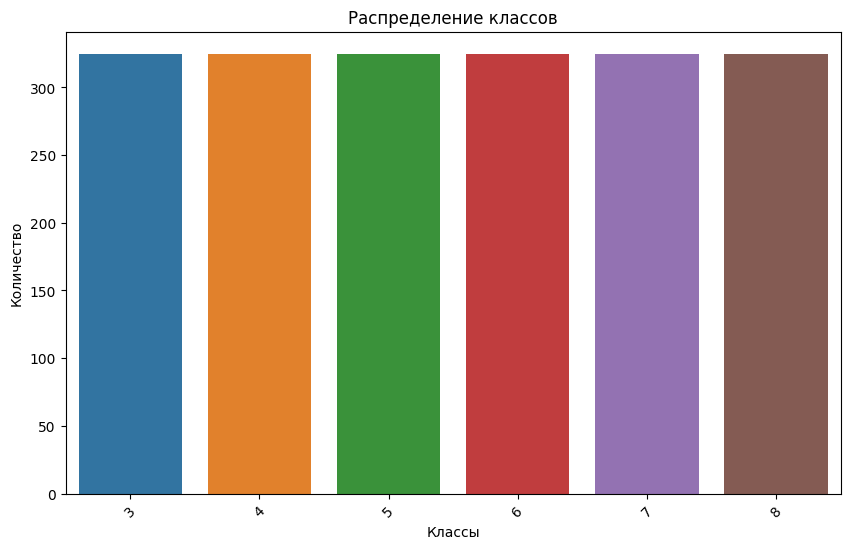

In [23]:
smote = SMOTE(random_state=42, k_neighbors=4)
X_train_wine_smote, y_train_wine_smote = smote.fit_resample(X_train_Wine, y_train_Wine)

class_counts = pd.Series(y_train_wine_smote).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Распределение классов')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Как заметно на графике, дисбаланс классов был полностью устранён, далее промасштабируем данные, это очень важно для моделей которые работают с расстоянием в данных

In [26]:
Scaler_wine = StandardScaler()
X_train_wine_smote_scale = Scaler_wine.fit_transform(X_train_wine_smote)
X_test_Wine_scale = Scaler_wine.transform(X_test_Wine)

Масштабируем данные ОБЯЗАТЕЛЬНО после train_test_split чтобы не было утечки данных в тестовую выборку и модель показывала корректные метрики

### Препроцессинг данных Регрессии Результаты студентов

In [30]:
Scaler_student = StandardScaler()
X_train_Student_scale = Scaler_student.fit_transform(X_train_Student)
X_test_Student_scale = Scaler_student.transform(X_test_Student)

### Создание моделей, обучение на обработанных данных и применение GridSearchCV для подбора гиперпараметров

In [60]:
GB_params_wine = {
    'learning_rate': [0.05, 0.05],
    'max_depth': [2, None],
    'min_samples_split': [1, 3, 5],
}

GB_wine = GradientBoostingClassifier()
GB_wine_grid = GridSearchCV(estimator=GB_wine, param_grid=GB_params_wine, cv=5)
GB_wine_grid.fit(X_train_wine_smote_scale, y_train_wine_smote)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.05], 'max_depth': [2, None],
                         'min_samples_split': [1, 3, 5]})

In [61]:
GB_params_student = {
    'learning_rate': [0.05, 0.05],
    'max_depth': [2, None],
    'min_samples_split': [1, 3, 5],
}

GB_student = GradientBoostingRegressor()
GB_student_grid = GridSearchCV(estimator=GB_student, param_grid=GB_params_student, cv=5)
GB_student_grid.fit(X_train_Student_scale, y_train_Student)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.05], 'max_depth': [2, None],
                         'min_samples_split': [1, 3, 5]})

После успешного обучения моделей, выведем метрики нового бейзлайна и сравним результаты

In [63]:
Wine_predict = GB_wine_grid.predict(X_test_Wine_scale)
Student_predict = GB_student_grid.predict(X_test_Student_scale)

print('Метрики Классификации качества Вина на новом бейзлайне:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов на новом бейзлайне:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина на новом бейзлайне:
Accuracy:  0.5343915343915344 
Recall:    0.5343915343915344 
Precision: 0.5747893451975086 
F1:        0.5522894698348104
Метрики Регрессии по экзаменам студентов на новом бейзлайне:
MAE:  3.2397002200340297 
RMSE: 4.165610179707074 
MAPE: 0.038515946218849934


### Метрики Классификации качества Вина на новом бейзлайне
Все метрики упали примерно на целых 0.1, что является довольно плохим результатом. Гиперпараметры ставили чуть больше и чуть меньше изначальных значений, чтобы попытаться найти более оптимальные, но оптимальными оказались базовые гиперпараметры.

### Метрики Регрессии по экзаменам студентов на новом бейзлайне
Метрики регрессии в свою очередь никак не поменялись.

# 4.Имплементация алгоритма машинного обучения 

### a. Самостоятельно имплементировать алгоритмы машинного обучения (для классификации и регрессии)
- Модель Дерева решений для классификации - Задача классификации качества вина

In [32]:
class OurDecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree_ = None
        self.classes_ = None

    def fit(self, X, y):
        # Преобразуем в numpy arrays
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Сохраняем уникальные классы и создаем mapping
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        # Создаем mapping из исходных меток в индексы 0..n_classes-1
        self.class_to_index_ = {cls: i for i, cls in enumerate(self.classes_)}
        y_encoded = np.array([self.class_to_index_[cls] for cls in y])
        
        self.tree_ = self._grow_tree(X, y_encoded)
        return self

    def predict(self, X):
        X = np.asarray(X)
        encoded_predictions = np.array([self._predict(x) for x in X])
        # Преобразуем обратно в исходные метки
        return np.array([self.classes_[idx] for idx in encoded_predictions])

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes_))

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((num / m) ** 2 for num in num_parent)
        best_idx, best_thr = None, None

        for idx in range(n):
            # Используем argsort для эффективного получения отсортированных значений
            sort_idx = np.argsort(X[:, idx])
            thresholds = X[sort_idx, idx]
            classes = y[sort_idx]
            
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()

            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((x / i) ** 2 for x in num_left)
                gini_right = 1.0 - sum((x / (m - i)) ** 2 for x in num_right)
                gini = (i * gini_left + (m - i) * gini_right) / m

                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples = len(y)
        
        # Находим наиболее частый класс
        if num_samples > 0:
            class_counts = [np.sum(y == c) for c in range(self.n_classes_)]
            predicted_class = np.argmax(class_counts)
        else:
            predicted_class = 0
        
        node = {
            "predicted_class": predicted_class,
            "num_samples": num_samples,
        }

        if (self.max_depth is None or depth < self.max_depth) and num_samples >= self.min_samples_split:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                node["feature_index"] = idx
                node["threshold"] = thr
                node["left"] = self._grow_tree(X[indices_left], y[indices_left], depth + 1)
                node["right"] = self._grow_tree(X[~indices_left], y[~indices_left], depth + 1)
                
        return node

    def _predict(self, x):
        node = self.tree_
        while "threshold" in node:
            if x[node["feature_index"]] < node["threshold"]:
                node = node["left"]
            else:
                node = node["right"]
        return node["predicted_class"]

- Модель Дерева решений для Регрессии - Задача регрессионной оценки по результатам студентов

In [34]:
class OurDecisionTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree_ = None

    def fit(self, X, y):
        # Преобразуем в numpy arrays
        X = np.asarray(X)
        y = np.asarray(y)
        self.tree_ = self._grow_tree(X, y)
        return self

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict(x) for x in X])

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2) if len(y) > 0 else 0

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        best_mse = self._mse(y)
        best_idx, best_thr = None, None

        for idx in range(n):
            # Используем argsort для эффективного получения отсортированных значений
            sort_idx = np.argsort(X[:, idx])
            thresholds = X[sort_idx, idx]
            values = y[sort_idx]
            
            for i in range(1, m):
                if thresholds[i] == thresholds[i - 1]:
                    continue
                    
                y_left, y_right = values[:i], values[i:]
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)
                mse_total = (len(y_left) * mse_left + len(y_right) * mse_right) / m

                if mse_total < best_mse:
                    best_mse = mse_total
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        num_samples = len(y)
        predicted_value = np.mean(y) if num_samples > 0 else 0
        
        node = {
            "predicted_value": predicted_value,
            "num_samples": num_samples
        }

        if (self.max_depth is None or depth < self.max_depth) and num_samples >= self.min_samples_split:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                node["feature_index"] = idx
                node["threshold"] = thr
                node["left"] = self._grow_tree(X[indices_left], y[indices_left], depth + 1)
                node["right"] = self._grow_tree(X[~indices_left], y[~indices_left], depth + 1)
                
        return node

    def _predict(self, x):
        node = self.tree_
        while "threshold" in node:
            if x[node["feature_index"]] < node["threshold"]:
                node = node["left"]
            else:
                node = node["right"]
        return node["predicted_value"]

    def get_params(self, deep=True):
        return {"max_depth": self.max_depth, "min_samples_split": self.min_samples_split}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

- Ансамбль Градиентного бустинга

In [36]:
class OurGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=5, task='reg'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.task = task
        self.trees = []
        self.initial = None
        self.classes_ = None
        
    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        
        if self.task == 'reg':
            # Регрессия - простая MSE
            self.initial = np.mean(y)
            pred = np.full(len(y), self.initial)
            
            for _ in range(self.n_estimators):
                tree = OurDecisionTreeRegressor(max_depth=self.max_depth)
                tree.fit(X, y - pred)
                update = tree.predict(X)
                pred += self.learning_rate * update
                self.trees.append(tree)
                
        else:
            # Классификация - многоклассовая
            self.classes_ = np.unique(y)
            n_classes = len(self.classes_)
            
            # One-hot кодирование
            y_oh = np.eye(n_classes)[np.searchsorted(self.classes_, y)]
            
            # Начальные логиты
            self.initial = np.zeros(n_classes)
            logits = np.zeros((len(y), n_classes))
            
            for _ in range(self.n_estimators):
                # Softmax вероятности
                exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
                probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
                
                # Градиенты
                grads = y_oh - probs
                
                # Деревья для каждого класса
                trees_iter = []
                for k in range(n_classes):
                    tree = OurDecisionTreeRegressor(max_depth=self.max_depth)
                    tree.fit(X, grads[:, k])
                    trees_iter.append(tree)
                    logits[:, k] += self.learning_rate * tree.predict(X)
                
                self.trees.append(trees_iter)
                
        return self
    
    def predict(self, X):
        X = np.asarray(X)
        
        if self.task == 'reg':
            pred = np.full(len(X), self.initial)
            for tree in self.trees:
                pred += self.learning_rate * tree.predict(X)
            return pred
            
        else:
            # Для классификации используем predict_proba
            proba = self.predict_proba(X)
            return self.classes_[np.argmax(proba, axis=1)]
    
    def predict_proba(self, X):
        if self.task == 'reg':
            raise ValueError("Только для классификации")
            
        X = np.asarray(X)
        n_classes = len(self.classes_)
        logits = np.zeros((len(X), n_classes))
        
        for trees_iter in self.trees:
            for k, tree in enumerate(trees_iter):
                logits[:, k] += self.learning_rate * tree.predict(X)
        
        # Softmax
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

### b. Обучить имплементированные модели (для классификации и регрессии) для выбранных наборов данных

In [48]:
gb_wine = OurGradientBoosting(task='class')
gb_Student = OurGradientBoosting()

gb_wine.fit(X_train_Wine, y_train_Wine)
gb_Student.fit(X_train_Student, y_train_Student)

### c. Оценить качество имплементированных моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных
### d. Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2 

In [49]:
Wine_predict = gb_wine.predict(X_test_Wine)
Student_predict = gb_Student.predict(X_test_Student)

print('Метрики Классификации качества Вина:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted", zero_division=True)} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина:
Accuracy:  0.6164021164021164 
Recall:    0.6164021164021164 
Precision: 0.6035967006495462 
F1:        0.6068773901917941
Метрики Регрессии по экзаменам студентов:
MAE:  3.2309488997192455 
RMSE: 4.166515921869482 
MAPE: 0.038402129726107216


### Метрики Имплементированной модели - Классификации качества Вина на первом бейзлайне
Метрики Имплементированной модели на базовой модели показали себя очень достойно. Модель из sklearn на базовом безлайне показала себя немного лучше, но данная модель так же справилась достойно.

### Метрики Имплементированной модели - Регрессии по экзаменам студентов на первом бейзлайне
Метрики Имплементированной модели на первом бейзлайне так же как и в случае с Классификацией показали себя достойно, модель может сравнится с Линейной регрессией. Никак не отличается от своего аналога из sklearn

### f. Добавить техники из улучшенного бейзлайна (пункт 3с)
- Функция для подбора гиперпараметров к модели и спользование Кросс-валидации

In [38]:
def gb_cv(X, y, task, n_estimators_list=[50, 100], learning_rates=[0.01, 0.1], 
                 max_depths=[2, 3], cv=3, random_state=42, sample_ratio=1.0):
    X = np.asarray(X)
    y = np.asarray(y)
    
    # Создаем param_grid из переданных параметров
    param_grid = {
        'n_estimators': n_estimators_list,
        'learning_rate': learning_rates,
        'max_depth': max_depths
    }
    
    # Применяем подвыборку если нужно
    if sample_ratio < 1.0:
        n_samples = int(len(X) * sample_ratio)
        rng = np.random.default_rng(random_state)
        indices = rng.choice(len(X), n_samples, replace=False)
        X = X[indices]
        y = y[indices]
        print(f"Используется подвыборка: {n_samples} samples ({sample_ratio*100:.1f}% данных)")
    
    n = X.shape[0]
    
    # Перемешиваем данные
    rng = np.random.default_rng(random_state)
    indices = rng.permutation(n)
    X, y = X[indices], y[indices]
    
    fold_size = n // cv
    best_score = -np.inf
    best_params = None
    
    # Перебираем все комбинации параметров
    for params in [dict(zip(param_grid.keys(), values)) 
                   for values in product(*param_grid.values())]:
        
        scores = []
        
        for i in range(cv):
            start = i * fold_size
            end = (i + 1) * fold_size if i < cv - 1 else n
            
            # Разделяем на train/val
            X_val, y_val = X[start:end], y[start:end]
            X_train = np.concatenate([X[:start], X[end:]])
            y_train = np.concatenate([y[:start], y[end:]])
            
            # Создаем и обучаем модель
            model = OurGradientBoosting(task=task, **params)
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            
            # Вычисляем score в зависимости от типа задачи
            if task == "classification" or task == "class":
                score = np.mean(preds == y_val)  # accuracy
            else:
                score = -np.mean((preds - y_val)**2)  # отрицательный MSE
            
            scores.append(score)
        
        avg_score = np.mean(scores)
        
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
    
    return best_params

### g. Обучить модели (для классификации и регрессии) для выбранных наборов данных
- Поиск гиперпараметров для Классификации и Регрессии

In [40]:
best_params_wine = gb_cv(X_train_wine_smote_scale, y_train_wine_smote, task="class", n_estimators_list =[50, 130],max_depths = [3, 7], learning_rates = [0.01, 0.5])

In [41]:
best_params_Student = gb_cv(X_train_Student_scale, y_train_Student, task="reg", n_estimators_list = [50, 130],max_depths = [3, 7], learning_rates = [0.01, 0.5], sample_ratio=0.25)

Используется подвыборка: 13400 samples (25.0% данных)


In [92]:
print(f'Лучшие параметры для Градиентного бустинга в задаче с классификацией вина: {best_params_wine}')
print(f'Лучшие параметры для Градиентного бустинга в задаче с регрессией оценок студентов: {best_params_Student}')

Лучшие параметры для Градиентного бустинга в задаче с классификацией вина: {'n_estimators': 130, 'learning_rate': 0.5, 'max_depth': 7}
Лучшие параметры для Градиентного бустинга в задаче с регрессией оценок студентов: {'n_estimators': 50, 'learning_rate': 0.5, 'max_depth': 3}


- Обучение моделей

In [101]:
GB_wine = OurGradientBoosting(n_estimators=best_params_wine['n_estimators'], learning_rate=best_params_wine['learning_rate'], max_depth=best_params_wine['max_depth'], task="class")

GB_Student = OurGradientBoosting(n_estimators=best_params_Student['n_estimators'], learning_rate=best_params_Student['learning_rate'], max_depth=best_params_Student['max_depth'], task="reg")

GB_wine.fit(X_train_wine_smote_scale, y_train_wine_smote)
GB_Student.fit(X_train_Student_scale, y_train_Student)

### h. Оценить качество моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

In [102]:
Wine_predict = GB_wine.predict(X_test_Wine_scale)
Student_predict = GB_Student.predict(X_test_Student_scale)

print('Метрики Классификации качества Вина на новом бейзлайне:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов на новом бейзлайне:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина на новом бейзлайне:
Accuracy:  0.5185185185185185 
Recall:    0.5185185185185185 
Precision: 0.5377365683978115 
F1:        0.5274083916838579
Метрики Регрессии по экзаменам студентов на новом бейзлайне:
MAE:  3.245938769735733 
RMSE: 4.192904838906656 
MAPE: 0.038593032695779655


### Метрики Имплементированной модели - Классификации качества Вина на новом бейзлайне
Метрики Имплементированной модели на новом бейзлайне - Модель себя показала хуже прошлого бейзлайна. Метрики упали примерно на 0.1, что является плохим результатом. Тоже самое произошло и с моделью из sklearn, там на новом безлайне метрики так же упали на 0.1

### Метрики Метрики Имплементированной модели - Регрессии по экзаменам студентов на первом бейзлайне
Метрики Имплементированной модели на новом бейзлайне - Модель на задач регрессии показала идентично прошлому безлайну, ничего не поменялось

# Вывод по проделанной работе

В ходе лабораторной работы мы работали с двумя датасетами - Данные на задачу много классовой классификации, оценить качество вина, вторая задача Регрессионного характера, предсказать результаты студентов исходя из их привычек и поведения студентов. В данной лабораторной работе мы изучили такой алгоритм машинного обучения как Градиентный бустинг, проверили его работоспособность на задаче как классификации, так и регрессии, провели небольшое исследования при каких условиях модель показывает себя с лучшей стороны. Лучшим из возможных стала модель из sklearn на базовом безлайне. Оно и справедливо, данная модель не нуждается в масштабировании данных, а так же не особо сильно ругается при дисбалансе классов.

# Общий вывод по всем работам 

В ходе выполнения всех пяти лабораторных работ мы познакомились с такими моделями как: Ближайшие соседи, Линейная-Логистическая регрессии, Дерево решений, Случайный лес и Градиентный бустинг, а так же провели исследования для каждой из модели на двух датасетах: Датасет много классовой классификации по качеству вина и регрессионная задача по оценкам студентов. В первой лабораторной работе мы работали с Методом ближайших соседей, а так же провели небольшой анализ данных. Посмотрели на распределение классов в классификации (проверка на дисбаланс), просмотрели корреляцию между признаками в обоих датасетах и посмотрели распределение целевой переменной в задачи регрессии, вся эта информаци нужна нам была для проведения второго безлайна для каждой из моделей, где мы полноценно обработали наши данные и устранили изъяны датасетов. Модели же проверялись на двух безлайнах: Первый - простая кодировка данных и ничего больше, Второй - Препроцессинг данных, это устраннение дисбаланса классов, масштабирование данных, а так же подбор гиперпараметров и применение кросс-валидации к моделям. Далее мы имплементировали модели (Ручное их написание) и проверяли так же работоспособность на обоих безлайнах. Среди всех моделей достойнее всех себя показали следующие модели:
- На задаче регрессии все модели, кроме KNN, показали себя достойно, но отдаём предпочтение Линейной регрессии, тк это самая лёгкая модель из всех.
- На задаче Классификации всё сложнее, все модели по метрикам справились не очень хорошо, связано это скорее всего с самими данными, но лучше всех справилась модель Случайного леса, выбив частоту правильных предсказаний равное 0.67, получили мы это на базовом безлайне, а не на втором. Связано это с тем, что Ансамбль случайный лес строится из множества обычных моделей дерева решений, которые очень устойчивы к дисбалансу классов, а так же не нуждаются в масштабированни данных.